# Overview of FlashAttention I-O Awareness

---
**Authors: Daniel Hocevar and Raghav Sharma**

This notebook contains a simulation of the expensive HBM GPU memory accesses across different three different ways of performing matrix multiplication : 1) standard matrix multiplication (no optimization), 2) matrix multiplication with tiling, and 3) low rank matrix multiplication with tiling (approximate solution). The notebook was created to present the I-O Awareness ideas used in the the paper "FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness" (https://arxiv.org/pdf/2205.14135). The layout of the notebook is as follows.

0. **Simulation Code and Fixed Parameters**: Defines the LRUSram, GPUMemoryHandler, and MemoryArray classes. Also defines constants that will be used for the simulation, such as the matrix and cache sizes.
* The *GPUMemoryHandler* class stores and keeps track of LRUSram accesses.
* The *MemoryArray* class is wrapper around numpy array that works with the GPUMemoryHandler to keep track of LRUSram accesses.

1. **Standard Matrix Multplication**: This section runs the simulation using standard matrix multiplication. This is the baseline which has the most hbm accesses.

2. **Matrix Multiplication with Tiling**: This section runs the simulation using matrix multiplication with tiling. This has a considerably less number of hbm accesses compared to the standard matrix multiplication approach.

3. **Low Rank Matrix Multiplication with Tiling**: This section runs the simulation using low rank matrix multiplication with tiling. This has the least number of hbm accesses but is an approximate solution. This is our original novelty, since it was not provided in the paper.

4. **HBM Accesses for the 3 Matrix Multplication methods, for varying SRAM sizes**: This section sees how each matrix multiplication performs in terms of its hbm accesses as the SRAM sizes increases.

# 0. Simulation Code
There are three classes defined here.
1. LRUSram is the SRAM our GPU simulation will use. It uses the least recently used eviction policy and predefined capacity.
2. GPUMemoryHandler keeps track of accesses to the LRUSram based on memory locations provided and updates the number of hbm accesses if a memory location was not already in the LRUSram.
3. MemoryArray is a wrapper around a NumpyArray but helps faciliate memory location tracking

In [1]:
import numpy as np
from collections import OrderedDict

class LRUSram:
    def __init__(self, capacity: int):
        """SRAM implemented based on the typical least recently used cache policy
        """
        self.cache = OrderedDict()
        self.capacity = capacity

    def put(self, memory_locations) -> bool:
        """Puts the specified memory locations into the RAM. Evicts if the RAM
        is full
        """
        # check if first address is in
        if (memory_locations[0] in self.cache):
            return True

        # not in so updating sram
        for memory_location in reversed(memory_locations):
            if (memory_location in self.cache):
                self.cache.move_to_end(memory_location)  # Mark as recently used
            else:
                self.cache[memory_location] = True

        while (len(self.cache) >= self.capacity):
            self.cache.popitem(last=False)  # Remove LRU item

        return False

class GPUMemoryHandler:
    def __init__(self, sram_size: int, locality_size: int):
        """Stores current memory locations in SRAM and how many hbm_accesses
        there has been thus far
        """
        self.sram = LRUSram(sram_size)
        self.locality_size = locality_size
        self.hbm_accesses = 0
        self.memory_counter = 0
        self.time = 0

    def update_sram(self, memory_location: int) -> None:
        """Updates SRAM based on the provided memory_location and its neighboring
        memory locations, determined by the locality size
        """
        first_h = memory_location - self.locality_size // 2
        second_h = self.locality_size // 2 + memory_location
        memory_locations = [memory_location] + \
            [i for i in range(first_h, memory_location)] + \
            [i for i in range(memory_location + 1, second_h + 1)]
        if (not self.sram.put(memory_locations)):
            self.hbm_accesses += 1


class MemoryArray:
    # Wrapper class over numpy array to track HBM accesses
    def __init__(self, data: np.array, memory_handler: GPUMemoryHandler):
        """Wrapper class over numpy array that stores corresponding memory
        locations. Works with the GPUMemoryHandler to track memory accesses
        """
        # Stores a numpy array and its corresponding memory locations based on
        # the memory handler's memory counter
        self.data = data
        self.shape = self.data.shape
        self.memory_locations = np.empty(data.shape, dtype=np.int32)
        self.memory_handler = memory_handler
        for i, j in np.ndindex(self.data.shape):
            self.memory_locations[i][j] = self.memory_handler.memory_counter
            self.memory_handler.memory_counter += 1

    def __getitem__(self, indices):
        """Will check if the address is in SRAM and update accordingly
        """
        if isinstance(indices, tuple) and len(indices) == 2:
            row, col = indices
            memory_location = self.memory_locations[row][col]
            self.memory_handler.update_sram(memory_location)

            return self.data[row][col]
        else:
            raise IndexError("Invalid number of indices, expected two.")

    def __setitem__(self, indices, value):
        """Will check if the address is in SRAM and update accordingly
        """
        if isinstance(indices, tuple) and len(indices) == 2:
            row, col = indices
            memory_location = self.memory_locations[row][col]
            self.memory_handler.update_sram(memory_location)

            self.data[row][col] = value
        else:
            raise IndexError("Invalid number of indices, expected two.")

    def __str__(self):
        return f"{self.data}"


# 0. Fixed Parameters

First we set some fixed parameters that will be used to test the different matrix multiplication algorithms.

We explicitly set integers N and d, corresponding to the matrix dimensions. Then using these dimensions, we generate random matrices A, B, and C, that will be used during matrix multiplication. In terms of GPU memory, we set the SRAM size, which indicates the maximum number of floating point numbers it can store. We also set the LOCALITY size, which indicates how many neighbouring elements in a matrix are cached, if an element is ever cache.



In terms of flashattention, N and d represent the sequence length and head dimension respectively. A is an N by d matrix, which can represent the Query matrix. B is a d by N matrix, which can represent the transpose of the Key matrix. Their product is an N by N matrix, which can represent the intermediate product matrix before softmax is applied to it. The SRAM and LOCALITY represent the limited SRAM of the GPU and its caching properties.


In [2]:
N = 50 # This can represent the sequence length
d = 10 # This represents the embedding dimension

A = np.random.rand(N, d) # This can represent the Query matrix
B = np.random.rand(d, N) # This can represent the Key matrix transposed
C = np.zeros((N, N)) # This can represent the intermediate S matrix

SRAM_SIZE = 15
LOCALITY_SIZE = 5

# 1. Standard Matrix Multplication (baseline)
This section contains the Standard Matrix Multplication (smm) code and its testing. Although the code is very short and simple, we will see that it leads to the most hbm accesses, which makes it very slow during execution.

The image below shows the standard matrix multiplication approach iterates through the rows of the first matrix A, columns of the second matrix B, to compute the dot product entry of the matrix C.
![Standard](https://siboehm.com/assets/img/MMM/Basic_MMM.png)

In [3]:
# Simple matrix multiplication code
def smm(A: MemoryArray, B: MemoryArray, C: MemoryArray):
    additions = 0
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                C[i,j] += A[i,k] * B[k,j]
                additions += 1

In [4]:
# Running smm code on our randomly generated A, B, and C matrices
smm_handler = GPUMemoryHandler(SRAM_SIZE, LOCALITY_SIZE)
A_smm = MemoryArray(A.copy(), smm_handler)
B_smm = MemoryArray(B.copy(), smm_handler)
C_smm = MemoryArray(C.copy(), smm_handler)
smm(A_smm, B_smm, C_smm)
print(f"smm hbm accesses are: {smm_handler.hbm_accesses}")

smm hbm accesses are: 50001


# 2. Matrix Multiplication with Tiling (Faster)
This section contains the Matrix Multplication with tiling (mml) code and its testing. Here we will see that it leads to a siginficant reduction in hbm accesses, which makes it very fast in practice.

The image below presents a detailed look into how tiling works in matrix multiplication.
![Tiling](https://www.cs.sfu.ca/~ashriram/Courses/CS7ARCH/hw/hw4/gemm_tiled.png)


In [5]:
# Matrix multiplication with tiling code
def mml(A: MemoryArray, B: MemoryArray, C: MemoryArray):
    # Set a tile size based on the locality
    tile_size = LOCALITY_SIZE

    # Loop over the each row in A
    for i in range(A.shape[0]):
        # Loop over each tile
        for tile in range(A.shape[1] // tile_size):
            # Loop over each row in B
            for j in range(B.shape[0]):
                # Loop over each cell in the tile
                for k in range(tile_size):
                    C[i, j] += A[i, tile * tile_size + k] * B[tile * tile_size + k, j]

In [6]:
# Running smm code on our randomly generated A, B, and C matrices
mml_handler = GPUMemoryHandler(SRAM_SIZE, LOCALITY_SIZE)

A_mml = MemoryArray(A.copy(), mml_handler)
B_mml = MemoryArray(B.copy(), mml_handler)
C_mml = MemoryArray(C.copy(), mml_handler)
mml(A_mml, B_mml, C_mml)
print(f"mml hbm accesses are: {mml_handler.hbm_accesses}")

mml hbm accesses are: 10600


# 3. Low Rank Matrix Multiplication with Tiling (Fastest but Approximate)
This section contains the low-rank Matrix Multplication with tiling (lrmml) code and its testing. Here we will see that it leads to even more reductions in hbm accesses, which makes it more fast in practice. Though the downside is that this is an approximate solution. Note the flashattention paper did not provide an implementation/algorithm of this low-rank matrix multplication approach, we are providing this as an original novelty.

The image below demonstrates how this approach works by decomposing a dense matrix into a two low rank products.

![Low Rank Approximation](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11227-020-03444-2/MediaObjects/11227_2020_3444_Fig1_HTML.png)

In [7]:
# Low rank matrix multiplication with tiling code
def lrmml(A: MemoryArray, B: MemoryArray, C: MemoryArray, memory_handler):
    # Define the low rank products
    B_1 = MemoryArray(np.expand_dims(B.data[:, 0], axis=0), memory_handler) # B_1 is the first column of B for simplicity
    B_2_T = MemoryArray(np.expand_dims(B.data[0], axis=0), memory_handler)  # B_2_T is the first row of B tranposed for simplicity
    C_temp = MemoryArray(C.data, memory_handler)
    # Set a tile size based on the locality
    tile_size = LOCALITY_SIZE

    # Multiply A and first low rank product
    for i in range(A.shape[0]):
        for tile in range(A.shape[1] // tile_size):
            for j in range(B_1.shape[0]):
                for k in range(tile_size):
                    C_temp[i, j] += A[i, tile * tile_size + k] * B_1[(tile * tile_size + k) % B_1.shape[0], j + (tile * tile_size + k) // B_1.shape[0]]

    # Multiply result with second low rank product to compute C
    for i in range(C_temp.shape[0]):
        for tile in range(C_temp.shape[1] // tile_size):
            for j in range(B_2_T.shape[0]):
                for k in range(tile_size):
                    C[i, j] += C_temp[i, tile * tile_size + k] * B_2_T[(tile * tile_size + k) % B_2_T.shape[0], j + (tile * tile_size + k) // B_2_T.shape[0]]

In [8]:
# Running smm code on our randomly generated A, B, and C matrices
lrmml_handler = GPUMemoryHandler(SRAM_SIZE, LOCALITY_SIZE)

A_lrmml = MemoryArray(A.copy(), lrmml_handler)
B_lrmml = MemoryArray(B.copy(), lrmml_handler)
C_lrmml = MemoryArray(C.copy(), lrmml_handler)
lrmml(A_lrmml, B_lrmml, C_lrmml, lrmml_handler)
print(f"lrmml hbm accesses are: {lrmml_handler.hbm_accesses}")

lrmml hbm accesses are: 3100


# 4. HBM Accesses for the 3 Matrix Multplication methods, for varying SRAM sizes
Finally for varying SRAM sizes, we plot how the hbm accesses change based on the matrix multiplication method we use. Note that as soon as the SRAM increases substantially, all the matrices' elements fit into the SRAM, and hence why we see the hbm accesses leveling off and becoming very small. Unfortunately in reality we do not have large amounts of SRAM because it is expensive to produce and there are phsyical limitations to how much we can have.



Text(0, 0.5, 'HBM accesses')

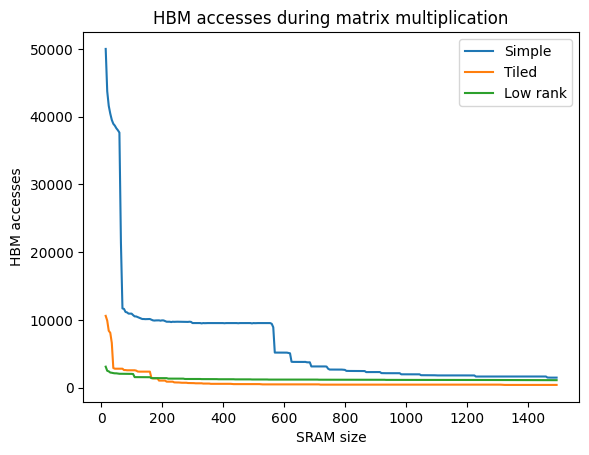

In [9]:
from matplotlib import pyplot as plt
sram_sizes = [x for x in range(15, 1500, 5)]

smm_hbm_accesses = []
for i in sram_sizes:
    smm_handler = GPUMemoryHandler(i, LOCALITY_SIZE)
    A_smm = MemoryArray(A.copy(), smm_handler)
    B_smm = MemoryArray(B.copy(), smm_handler)
    C_smm = MemoryArray(C.copy(), smm_handler)
    smm(A_smm, B_smm, C_smm)
    smm_hbm_accesses.append(smm_handler.hbm_accesses)


mml_hbm_accesses = []
for i in sram_sizes:
    mml_handler = GPUMemoryHandler(i, LOCALITY_SIZE)
    A_mml = MemoryArray(A.copy(), mml_handler)
    B_mml = MemoryArray(B.copy(), mml_handler)
    C_mml = MemoryArray(C.copy(), mml_handler)
    mml(A_mml, B_mml, C_mml)
    mml_hbm_accesses.append(mml_handler.hbm_accesses)

lrmml_hbm_accesses = []
for i in sram_sizes:
    lrmml_handler = GPUMemoryHandler(i, LOCALITY_SIZE)
    A_lrmml = MemoryArray(A.copy(), lrmml_handler)
    B_lrmml = MemoryArray(B.copy(), lrmml_handler)
    C_lrmml = MemoryArray(C.copy(), lrmml_handler)
    lrmml(A_lrmml, B_lrmml, C_lrmml, lrmml_handler)
    lrmml_hbm_accesses.append(lrmml_handler.hbm_accesses)


plt.plot(sram_sizes, smm_hbm_accesses, label='Simple')
plt.plot(sram_sizes, mml_hbm_accesses, label='Tiled')
plt.plot(sram_sizes, lrmml_hbm_accesses, label='Low rank')
plt.legend()
plt.title("HBM accesses during matrix multiplication")
plt.xlabel("SRAM size")
plt.ylabel("HBM accesses")
